# Simpler case: ignore noise

$$
\begin{align}
\text{MI}(Y;N) &= \sum_{n} p_N(n) \sum_{y} p_{Y|N}(y|n,\theta) \left( \log p_{Y|N}(y|n, \theta) - \log p_Y(y | \theta) \right) \\
&= - \sum_{n} p_N(n) \log p_Y(\hat y(n, \theta) | \theta) = - \sum_{n} p_N(n) \log \left( \sum_{k: \hat y(n, \theta) = \hat y(k, \theta)} p_N(k)\right) \\ 
&= - \sum_{s\in \Chi} p_S(s|\theta) \log p_S(s|\theta) \\
\text{ where } p_S(s|\theta) &= \sum_{k \in s} p_N(k) \\ 
\text{ and } \Chi =& \{\hat y^{-1}(y, \theta) : y \in \{0,2^B-1\}\}\\ 
\end{align}
$$

For evenly $K$ spaced bins with spacing $\alpha$ starting at $\beta$ plus one bin stretching to infinity in each direction, and enumerating these bins from left to right, we have $p_S(s_i) = \sum_{k \in s_i} p_N(k)$ where $s_0 = \{ -\infty, ..., \lfloor \beta \rfloor \}$, $s_i = \{ \lceil \beta + \alpha(i-1) \rceil, ..., \lfloor \beta + \alpha i \rfloor \}$ for $i = 1, ..., K$, and $s_{K+1} = \{ \lceil \beta + \alpha K \rceil, \infty \}$.

Hence the probabilities are $p_S(s_0) = F_N(\lfloor \beta \rfloor)$, $p_S(s_i) = F_N(\lfloor \beta + \alpha i \rfloor) - F_N(\lceil \beta + \alpha(i-1) \rceil)$ for $i = 1, ..., K$, and $p_S(s_{K+1}) = 1 - F_N(\lceil \beta + \alpha K \rceil)$.

In [216]:
from functools import partial
import jax
from jax import numpy as jnp
from numpyro import distributions as dists
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [217]:
def compute_even_levels(num_bins, alpha, beta, offset_fixed=0):
    shape = jnp.broadcast_shapes(jnp.shape(alpha), jnp.shape(beta), jnp.shape(offset_fixed))
    i = jnp.arange(num_bins+1).reshape(-1, *[1]*len(shape))
    offset_scaled = -(num_bins +1) / 2
    res = alpha * (i + 0.5 + offset_scaled) + beta + offset_fixed
    return res.at[0, ...].set(-jnp.inf).at[-1, ...].set(jnp.inf)
    
@partial(jax.jit, static_argnums=(2,))
def MI(alpha, beta, K, values, probabilities):

    levels = compute_even_levels(K, alpha, beta, offset_fixed=(values[0] + values[-1]) / 2)
    alpha, beta = jnp.atleast_1d(alpha)[jnp.newaxis, ...], jnp.atleast_1d(beta)[jnp.newaxis, ...]

    cumprobs = jnp.concat([jnp.array([0.0]), jnp.cumsum(probabilities)])

    p_s = cumprobs[jnp.searchsorted(values, levels[1:,...])] - cumprobs[jnp.searchsorted(values, levels[:-1,...])]

    return -jnp.sum(p_s * jnp.log2(p_s), where=p_s > 0, axis=0)

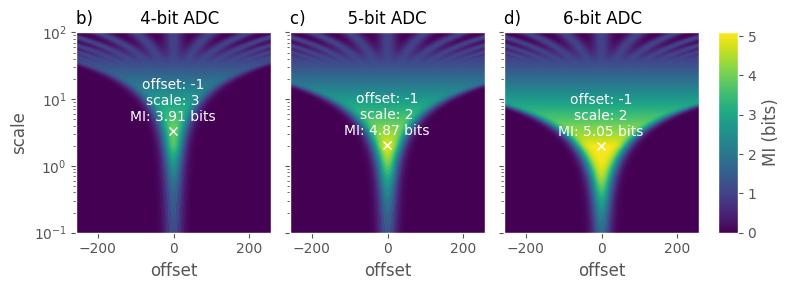

In [247]:
fig, ax = plt.subplots(1,4, width_ratios=[10,10,10,1], figsize=(8, 3))

ax[1].sharex(ax[0])
ax[2].sharex(ax[0])

# ax[3].axis("off")

d = dists.Binomial(256, 0.5)
support = jnp.array(d.enumerate_support())*2 - 256
probabilities = jnp.exp(d.log_prob(d.enumerate_support()))

phase = jnp.linspace(-256, 256, 1000)
scale = jnp.logspace(-1, 2, 1000)


vmin, vmax = 0, jnp.log2(4*jnp.pi*jnp.e)

cases = [("b)         4-bit ADC",4),("c)        5-bit ADC",5),("d)        6-bit ADC",6)]
for i,(label,bits) in enumerate(cases):
    # compute MI for different scales and phases
    MIs = MI(*jnp.ix_(scale, phase), 2**bits, support, probabilities)
    
    # compute optimum
    max_idx = MIs.argmax()
    max_scale_idx, max_phase_idx = jnp.unravel_index(max_idx, MIs.shape)
    max_scale = scale[max_scale_idx]
    max_phase = phase[max_phase_idx]
    max_MI = MIs[max_scale_idx, max_phase_idx]

    im = ax[i].pcolormesh(phase.ravel(), scale.ravel(), MIs, vmin=vmin, vmax=vmax, rasterized=True)
    ax[i].set_yscale("log")
    ax[i].plot(phase[max_phase_idx], scale[max_scale_idx], "wx")
    ax[i].set_title(label, fontsize=12, loc="left")

    # annotate optimum
    ax[i].annotate(f"offset: {max_phase:.0f}\nscale: {max_scale:.0f}\nMI: {max_MI:.2f} bits", (max_phase, max_scale), (0,5), va="bottom", ha="center", textcoords="offset points", fontsize=10, color="white")

    # hide inner axis decorations
    if i != 0:
        ax[i].set_yticklabels([])

    fig.colorbar(im, ax=ax, cax=ax[3], label="MI (bits)")
    ax[i].set_xlabel("offset")

ax[0].set_ylabel("scale")
fig.tight_layout()

fig.savefig("../figures/optimum.pdf", bbox_inches="tight")
fig.savefig("../figures/optimum.svg", bbox_inches="tight")
fig.savefig("../figures/optimum.png", bbox_inches="tight", dpi=300)

In [194]:
# plot vector length vs number of ADC bits, offset and scale

from tqdm import tqdm

# phase offset can be -1, -0.5, or 0 (we started with centered bins)
phase = jnp.array([-1, -0.5, 0])
scale = jnp.logspace(-1, 2, 1000)

vector_length = 2**jnp.arange(1, 16.1, 0.125)
enobs = []
cases = [("low-res.", -1), ("mid-res.", 0), ("high-res.", 1)]
max_MIs = [[] for _ in range(len(cases))]
num_bits = [[] for _ in range(len(cases))]
max_scales = [[] for _ in range(len(cases))]
max_phases = [[] for _ in range(len(cases))]
max_ranges = [[] for _ in range(len(cases))]
max_widths = [[] for _ in range(len(cases))]

for vl in tqdm(vector_length):
    # generate distribution for given vector length
    d = dists.Binomial(vl, 0.5)
    support = jnp.array(d.enumerate_support())*2 - vl
    probabilities = jnp.exp(d.log_prob(d.enumerate_support()))

    # compute ENOB
    ENOB = jnp.log2(2*jnp.e*jnp.pi*0.25*vl)*0.5
    enobs.append(ENOB)

    # low bit-precision is rounded down, high bit-precision is rounded up
    for i,bits in enumerate([int(ENOB) + o for (_,o) in cases]):

        # compute MI for low and high precision
        MIs = MI(*jnp.ix_(scale, phase), 2**bits, support, probabilities)

        # find location of the maximum MI for low precision    
        max_idx= MIs.argmax()
        max_scale_idx, max_phase_idx= jnp.unravel_index(max_idx, MIs.shape)
        max_scale= scale[max_scale_idx]
        max_phase= phase[max_phase_idx]
        max_MI= MIs[max_scale_idx, max_phase_idx]

        # compute which range the central bins cover
        covered_range= max_scale* (2**bits - 1)

        # compute how many numbers fall within each central bin
        offset_fixed = (support[0] + support[-1]) / 2
        levels= compute_even_levels(2**bits, max_scale, max_phase, offset_fixed=offset_fixed)
        (vals, counts) = jnp.unique_counts(jnp.searchsorted(levels, support))
        max_width= jnp.sum(counts, where=(vals > 1) & (vals < (2**bits)-2)) / (2**bits - 2)

        # track results
        num_bits[i].append(int(bits))
        max_MIs[i].append(float(max_MI))
        max_scales[i].append(float(max_scale))
        max_ranges[i].append(float(covered_range))
        max_widths[i].append(float(max_width))

num_bits = jnp.array(num_bits)
max_MIs = jnp.array(max_MIs)
max_scales = jnp.array(max_scales)
max_phases = jnp.array(max_phases)
max_ranges = jnp.array(max_ranges)
max_widths = jnp.array(max_widths)


  0%|          | 0/121 [00:00<?, ?it/s]

100%|██████████| 121/121 [00:35<00:00,  3.42it/s]


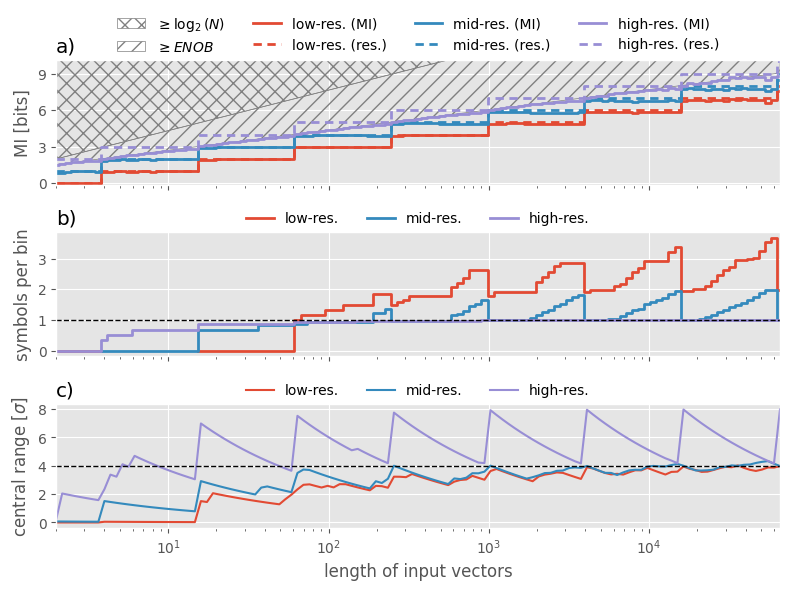

In [195]:
from matplotlib.ticker import MaxNLocator


fig, (ax_MI, ax_scales, ax_range) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

ymin, ymax = -0.1, 10.1
xmin, xmax = vector_length[0], vector_length[-1]
    
# hatch the completely unachievable region
ax_MI.fill_between(
    vector_length,
    1 + jnp.log2(vector_length),
    jnp.zeros_like(vector_length) + ymax,
    label="$\\geq\\log_2(N)$",
    edgecolor="gray",
    facecolor="none",
    hatch="XX",
)

# hatch the unachievable region > ENOB
ax_MI.fill_between(
    vector_length,
    1 + jnp.log2(vector_length),
    enobs,
    label="$\\geq ENOB$",
    edgecolor="gray",
    facecolor="none",
    hatch="//",
)

# plot the individual results for each case
for i, (label, offset) in enumerate(cases):
    # plot the limit and measured MI
    ax_MI.step(
        vector_length, 
        max_MIs[i], 
        label=f"{label} (MI)", 
        where="mid", 
        color=f"C{i}", 
        lw=2
    )
    
    ax_MI.step(
        vector_length,
        num_bits[i],
        "--",
        dashes = [3,2],
        label=f"{label} (res.)",
        where="mid",
        color=f"C{i}",
        lw=2,
    )

    # plot the average number of values that fall within the central bins
    ax_scales.step(vector_length, max_widths[i], where="mid", label=label, color=f"C{i}", lw=2)

    # plot the covered range of the central bins in standard deviations
    ax_range.plot(vector_length, jnp.array(max_ranges[i]) / jnp.sqrt(vector_length), label=label)

ax_MI.set_xscale("log")
ax_MI.set_ylabel("MI [bits]")
ax_MI.set_ylim(ymin, ymax)
ax_MI.set_xlim(xmin, xmax)

ax_scales.hlines([1.0], xmin, xmax, lw=1, linestyles="--", color="black")
ax_scales.set_ylabel("symbols per bin")

ax_range.hlines([4.0], xmin, xmax, lw=1, linestyles="--", color="black")
ax_range.set_xlabel("length of input vectors")
ax_range.set_ylabel("central range [$\\sigma$]")

# set integer locators for each plot
ax_MI.yaxis.set_major_locator(MaxNLocator(5, integer=True))
ax_scales.yaxis.set_major_locator(MaxNLocator(5, integer=True))
ax_range.yaxis.set_major_locator(MaxNLocator(5, integer=True))

ax_MI.set_title("a)", loc="left")
ax_scales.set_title("b)", loc="left")
ax_range.set_title("c)", loc="left")

ax_MI.legend(loc="lower center", bbox_to_anchor=(0.5, 0.95), fancybox=False, facecolor="none", edgecolor="none", ncol=4)
ax_scales.legend(loc="lower center", bbox_to_anchor=(0.5, 0.95), fancybox=False, facecolor="none", edgecolor="none", ncol=3)
ax_range.legend(loc="lower center", bbox_to_anchor=(0.5, 0.95), fancybox=False, facecolor="none", edgecolor="none", ncol=3)

fig.tight_layout()

fig.savefig("../figures/range.pdf", bbox_inches="tight")
fig.savefig("../figures/range.svg", bbox_inches="tight")
fig.savefig("../figures/range.png", bbox_inches="tight", dpi=300)